In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
from textblob import TextBlob
import itertools
from random import choice
from matplotlib import cm

### Opening path to data

In [2]:
os.path.exists("D:\\graphs\\outputacm.txt")

False

In [3]:
path = "outputacm.txt"
if os.path.exists("D:\\graphs\\outputacm.txt"):
    path = "D:\\graphs\\outputacm.txt"

test = open(path, 'r',  encoding="utf8") 
test.readlines()[0:100]

['629814\n',
 '#*Automated Deduction in Geometry: 5th International Workshop, ADG 2004, Gainesville, FL, USA, September 16-18, 2004, Revised Papers (Lecture Notes in Computer ... / Lecture Notes in Artificial Intelligence)\n',
 '#@Hoon Hong,Dongming Wang\n',
 '#t2006\n',
 '#c\n',
 '#index0\n',
 '\n',
 '#*A+ Certification Core Hardware (Text & Lab Manual)\n',
 '#@Charles J. Brooks\n',
 '#t2003\n',
 '#c\n',
 '#index1\n',
 '\n',
 '#*Performance engineering in industry: current practices and adoption challenges\n',
 '#@Ahmed E. Hassan,Parminder Flora\n',
 '#t2007\n',
 '#cProceedings of the 6th international workshop on Software and performance\n',
 '#index2\n',
 '#!This panel session discusses performance engineering practices in industry. Presentations in the session will explore the use of lightweight techniques and approaches in order to permit the cost effective and rapid adoption of performance modeling research by large industrial software systems.\n',
 '\n',
 '#*Dude, You Can Do It!

### Methods for parsing citation data

works for aminer citation sets V1-V10

In [4]:
def create_graph(graph, reference):
    graph.add_node(reference['index']) # add node
    graph.add_node(reference['index'], title=reference['title']) # add title attribute to node
    graph.add_node(reference['index'], journal=reference['journal']) # add journal attribute to node
    if 'abstract' in reference:
        graph.add_node(reference['index'], abstract=reference['abstract']) # add abstract attribute to node
    else:
        graph.add_node(reference['index'], abstract="")
    for citation in reference['citations']:
        graph.add_edge(reference['index'], citation) # add edge to node

In [5]:
def parse_data(graph):
    with open(path, 'r',  encoding="utf8") as f:
        reference={}
        citations=[]
        readFile = f.readlines()
        for line in readFile:
            
            if '#*' in line: # article title
                if (bool(reference)):
                    reference['citations'] = citations
                    citations=[]
                    create_graph(graph, reference)
                    try:
                        yield reference
                    except IndexError as e:
                        continue
                    reference={}
                reference['title'] = line[2:].rstrip()
            elif '#@' in line: # authors
                reference['author'] = line[2:].rstrip().rsplit(";")
            elif '#t' in line: # year published
                reference['year'] = line[2:].rstrip()
            elif '#c' in line: # journal
                reference['journal'] = line[2:].rstrip()
            elif '#index' in line: # index
                reference['index'] = line[6:].rstrip()
            elif '#%' in line: # id of cited paper
                citations.append(line[2:].rstrip())
            elif '#!' in line: # abstract
                reference['abstract'] = line[2:].rstrip()
                if (bool(reference)):
                    reference['citations'] = citations
                    citations=[]
                    create_graph(graph, reference)
        yield reference
        create_graph(graph, reference)
        return reference

### Create NetworkX Graph G and pandas dataframe data from parsed citation data 

In [6]:
G = nx.DiGraph()

In [7]:
data = pd.DataFrame(parse_data(G), columns =('index', 'title', 'author',
                                            'year', 'journal', 'citations', 'abstract'))

In [8]:
print(G.number_of_nodes(), 'nodes')
print(G.size(), 'edges')

629814 nodes
632751 edges


Data structure preview:

In [9]:
data

,index,title,author,year,journal,citations,abstract
0,0,Automated Deduction in Geometry: 5th Internati...,"[Hoon Hong,Dongming Wang]",2006,,[],NaN
1,1,A+ Certification Core Hardware (Text & Lab Man...,[Charles J. Brooks],2003,,[],NaN
2,2,Performance engineering in industry: current p...,"[Ahmed E. Hassan,Parminder Flora]",2007,Proceedings of the 6th international workshop ...,[],This panel session discusses performance engin...
3,3,"Dude, You Can Do It! How to Build a Sweeet PC","[Darrel Creacy,Carlito Vicencio]",2005,,[],Whether you're frustrated with current PC offe...
4,4,What Every Programmer Needs to Know about Secu...,"[Neil Daswani,Anita Kesavan]",2006,,[],NaN
...,...,...,...,...,...,...,...
629809,629809,Mining A,[],2008,Proceedings of the VLDB Endowment,[],NaN
629810,629810,Review article,[],2008,Communications of the ACM,[],NaN
629811,629811,Multimodal system evaluation using modality ef...,"[Manolis Perakakis,Alexandros Potamianos]",2008,Proceedings of the 10th international conferen...,[],"In this paper, we propose two new objective me..."
629812,629812,Computer System Architecture,[V. K. Jain],2007,,[],NaN


### Removing nodes without edges

In [10]:
G.remove_nodes_from(list(nx.isolates(G)))

In [11]:
print("After removing isolated nodes, the network contains:")
print(G.number_of_nodes(), 'nodes')
print("Obviously edges are the same.")
print(G.size(), 'edges')

After removing isolated nodes, the network contains:
217335 nodes
Obviously edges are the same.
632751 edges


### Methods for examining shared phrases using TextBlob NLP

In [12]:
#wordlist is the wordlist of the central node and comparison is wordlist of one of it's neighbor
def shared_noun_phrases(wordlist, comparison):
    count=0
    for word in wordlist:
        if word in comparison:
            count+=1
    if (len(wordlist) == 0):
        return 0
    return count/len(wordlist)

In [13]:
def find_noun_phrases(graph, starting_node):
    noun_phrases= TextBlob(graph.nodes[starting_node]['abstract']).noun_phrases
    data_set=[]
    index=str(starting_node)
    for neighbor in graph.predecessors(index):
        if 'abstract' in graph.nodes[neighbor].keys():
            data_set.append(shared_noun_phrases(noun_phrases, TextBlob(graph.nodes[neighbor]['abstract']).noun_phrases))
    return noun_phrases, data_set

Here is an example of the output of the TextBlob noun phrase extraction:

In [14]:
print(find_noun_phrases(G, '629811')[0])

['new objective metrics', 'relative modality efficiency', 'multimodal synergy', 'valuable information', 'identify usability problems', 'multimodal systems', 'relative', 'modality efficiency', 'modality usage', 'identify suboptimal use', 'poor interface design', 'information asymmetries', 'multimodal', 'synergy measures', 'multiple input modalities', 'modality fusion', 'multimodal system', 'multimodal systems', 'mouse/keyboard modalities', 'multimodal interface usability issues', 'multimodal systems', 'maximize modalities synergy', 'intelligent multimodal interfaces']


### Method for removing nodes without abstracts

In [15]:
def graph_only_nodes_with_abstract(graph):
    no_abstracts = graph.copy()
    for node in [x for x, y in graph.nodes(data=True) if y['abstract']=='']:
        no_abstracts.remove_node(node)
    #print(no_abstracts.number_of_nodes(), 'nodes after removing abstractless nodes')
    return no_abstracts

### Selecting  nodes from the graph

In [16]:
def select_n_nodes_with_average_degrees(graph, n):
    G_no_isolated = graph.copy()
    G_no_isolated.remove_nodes_from(list(nx.isolates(G_no_isolated)))
    #print(G.number_of_nodes(), 'nodes in G,', G_no_isolated.number_of_nodes(), 'nodes in G_no_isolated')
    node_list = [seq[0] for seq in sorted(G_no_isolated.degree, key=lambda x: x[1], reverse=True) ]
    halfway_point = int(len(node_list)/7)
    return node_list[halfway_point:(halfway_point+n)]

In [17]:
def select_n_nodes_with_highest_degrees(graph, n):
    node_list = [ seq[0] for seq in sorted(graph.degree, key=lambda x: x[1], reverse=True)[0:n] ]
    return node_list[0:n]

### Calculate abstract similarity to neighbours percentage

In [18]:
def abstract_similarity_percentage(list):
    if len(list) != 0:
        return sum(list)/len(list)
    return 0

### Similarity comparison methods

In [19]:
def make_comparison(graph, starting_node):
    noun_phrases= TextBlob(graph.nodes[starting_node]['abstract']).noun_phrases
    #data_set=[noun_phrases]
    data_set=[]
    random_node=take_random_node(graph, starting_node)
    for neighbor in graph.predecessors(random_node):
        if 'abstract' in graph.nodes[neighbor].keys():
            data_set.append(shared_noun_phrases(noun_phrases, TextBlob(graph.nodes[neighbor]['abstract']).noun_phrases))
    return random_node, noun_phrases, data_set
    

In [20]:
def take_random_node(graph, starting):
    while(True):
        random_node=choice(list(graph.nodes()))
        if random_node not in graph.neighbors(starting) and graph.in_degree[random_node]>10:
            return random_node
    return None

In [21]:
def calculate_total_similarities(graph, nodes):
    data=[]
    for node in nodes:
        data.append(abstract_similarity_percentage(find_noun_phrases(graph_only_nodes_with_abstract(graph), node)[1]))
    return data

In [22]:
def calculate_total_similarities_random(graph, nodes):
    data=[]
    for node in nodes:
        data.append(abstract_similarity_percentage(make_comparison(graph_only_nodes_with_abstract(graph), node)[2]))
    return data

### Selecting nodes/articles to be used

Taking a selection of nodes

In [23]:
node_count = 20
average_degree_nodes = select_n_nodes_with_average_degrees(graph_only_nodes_with_abstract(G), node_count)
print("Selected nodes have", G.degree(average_degree_nodes[node_count-1]), " edges (or more).")
#for node in average_degree_nodes:
#    print(G.degree(node))

highest_degree_nodes = select_n_nodes_with_highest_degrees(graph_only_nodes_with_abstract(G), node_count)

Selected nodes have 10  edges (or more).


In [24]:
dataMedian=calculate_total_similarities(G, average_degree_nodes)
dataHigh=calculate_total_similarities(G, highest_degree_nodes)

dataHighRandom=calculate_total_similarities_random(G, highest_degree_nodes)
dataMedianRandom=calculate_total_similarities_random(G, average_degree_nodes)

print(dataHigh)
print(dataHighRandom)

[0.004140127388535034, 0.012987012987012995, 0.00449438202247191, 0.010070869078701973, 0.03126897389192466, 0.006644518272425248, 0.017067003792667505, 0.007669749605233476, 0.01737451737451737, 0.05935147654892881, 0.013221153846153846, 0.0004653327128897161, 0.0007584376185058779, 0.016109045848822775, 0.0119047619047619, 0.17379032258064495, 0.031060606060606046, 0.000496031746031746, 0.006909090909090912, 0.013824884792626734]
[0.0018867924528301887, 0.0, 0.0, 0.0, 0.006944444444444444, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0030864197530864196, 0.00207641196013289, 0.0, 0.0, 0.0, 0.0, 0.0]


Testing similarity method

In [25]:
print("Highest degree node similarity:")
for node_index in highest_degree_nodes:
    #print(find_noun_phrases(G, node_index)[0])  # uncomment me to see noun phrases
    print("Node:", node_index, "// Similarity to neighbouring article abstracts:", abstract_similarity_percentage(find_noun_phrases(graph_only_nodes_with_abstract(G), node_index)[1]))
print("")
print("Average degree node similarity:")
for node_index in average_degree_nodes:
    #print(find_noun_phrases(G, node_index)[0])  # uncomment me to see noun phrases
    print("Node:", node_index, "// Similarity to neighbouring article abstracts:", abstract_similarity_percentage(find_noun_phrases(graph_only_nodes_with_abstract(G), node_index)[1]))

Highest degree node similarity:
Node: 326368 // Similarity to neighbouring article abstracts: 0.004140127388535034
Node: 151297 // Similarity to neighbouring article abstracts: 0.012987012987012995
Node: 319217 // Similarity to neighbouring article abstracts: 0.00449438202247191
Node: 207703 // Similarity to neighbouring article abstracts: 0.010070869078701973
Node: 250081 // Similarity to neighbouring article abstracts: 0.03126897389192466
Node: 330862 // Similarity to neighbouring article abstracts: 0.006644518272425248
Node: 445663 // Similarity to neighbouring article abstracts: 0.017067003792667505
Node: 616075 // Similarity to neighbouring article abstracts: 0.007669749605233476
Node: 178287 // Similarity to neighbouring article abstracts: 0.01737451737451737
Node: 231782 // Similarity to neighbouring article abstracts: 0.05935147654892881
Node: 246511 // Similarity to neighbouring article abstracts: 0.013221153846153846
Node: 327827 // Similarity to neighbouring article abstract

In [26]:
print(dataHigh)
print(len(dataHighRandom))
for thing in dataHighRandom:
    print(thing)

[0.004140127388535034, 0.012987012987012995, 0.00449438202247191, 0.010070869078701973, 0.03126897389192466, 0.006644518272425248, 0.017067003792667505, 0.007669749605233476, 0.01737451737451737, 0.05935147654892881, 0.013221153846153846, 0.0004653327128897161, 0.0007584376185058779, 0.016109045848822775, 0.0119047619047619, 0.17379032258064495, 0.031060606060606046, 0.000496031746031746, 0.006909090909090912, 0.013824884792626734]
20
0.0018867924528301887
0.0
0.0
0.0
0.006944444444444444
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0030864197530864196
0.00207641196013289
0.0
0.0
0.0
0.0
0.0


## Draw the networks

In [27]:
def get_subgraph(G, starting_node):
    """Graph: a bigger graph to get the subgraph of
       starting node: the central node to extract predecessors of
       returns a subgraph of the central node and its predecessors
    """
    nodes_list = [starting_node]
    for n in list(G.predecessors(starting_node)):
        nodes_list.append(n)
    subgraph = G.subgraph(nodes_list).copy()
    return subgraph

In [28]:
def draw_network(subgraph, data, size_of_nodes, to_file):
    """Graph: the subgraph to be plotted
       Data: a list of values between 0 and 1, denoting the percentage of shared noun phrases
       with the central node
    """
    max_data = max(data)
    try:
        normalized_data = [d/max_data for d in data]
    except ZeroDivisionError:
        normalized_data = data
    blue_map = cm.get_cmap('bwr', len(subgraph))
    color_list = [blue_map(d) for d in normalized_data]
    if not to_file:
        nx.draw_spring(subgraph, node_color=color_list, node_size=size_of_nodes)
    else:
        nx.draw_spring(subgraph, node_color=color_list, node_size=size_of_nodes)
        plt.savefig("Graph.png", format="PNG")

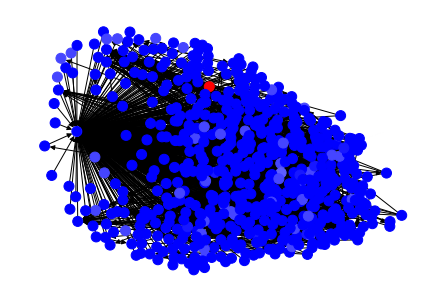

In [29]:
def create_plot(node_number, size_of_nodes, to_file):
    subgraph = get_subgraph(G, node_number)
    _, data = find_noun_phrases(subgraph, node_number)
    # add color of the 1st node (add 0 as the 1st element of the list)
    data.insert(0, 1)
    draw_network(subgraph, data, size_of_nodes, to_file)

size_of_nodes = 100
to_file = False
node_number = '151297'
create_plot(node_number, size_of_nodes, to_file)